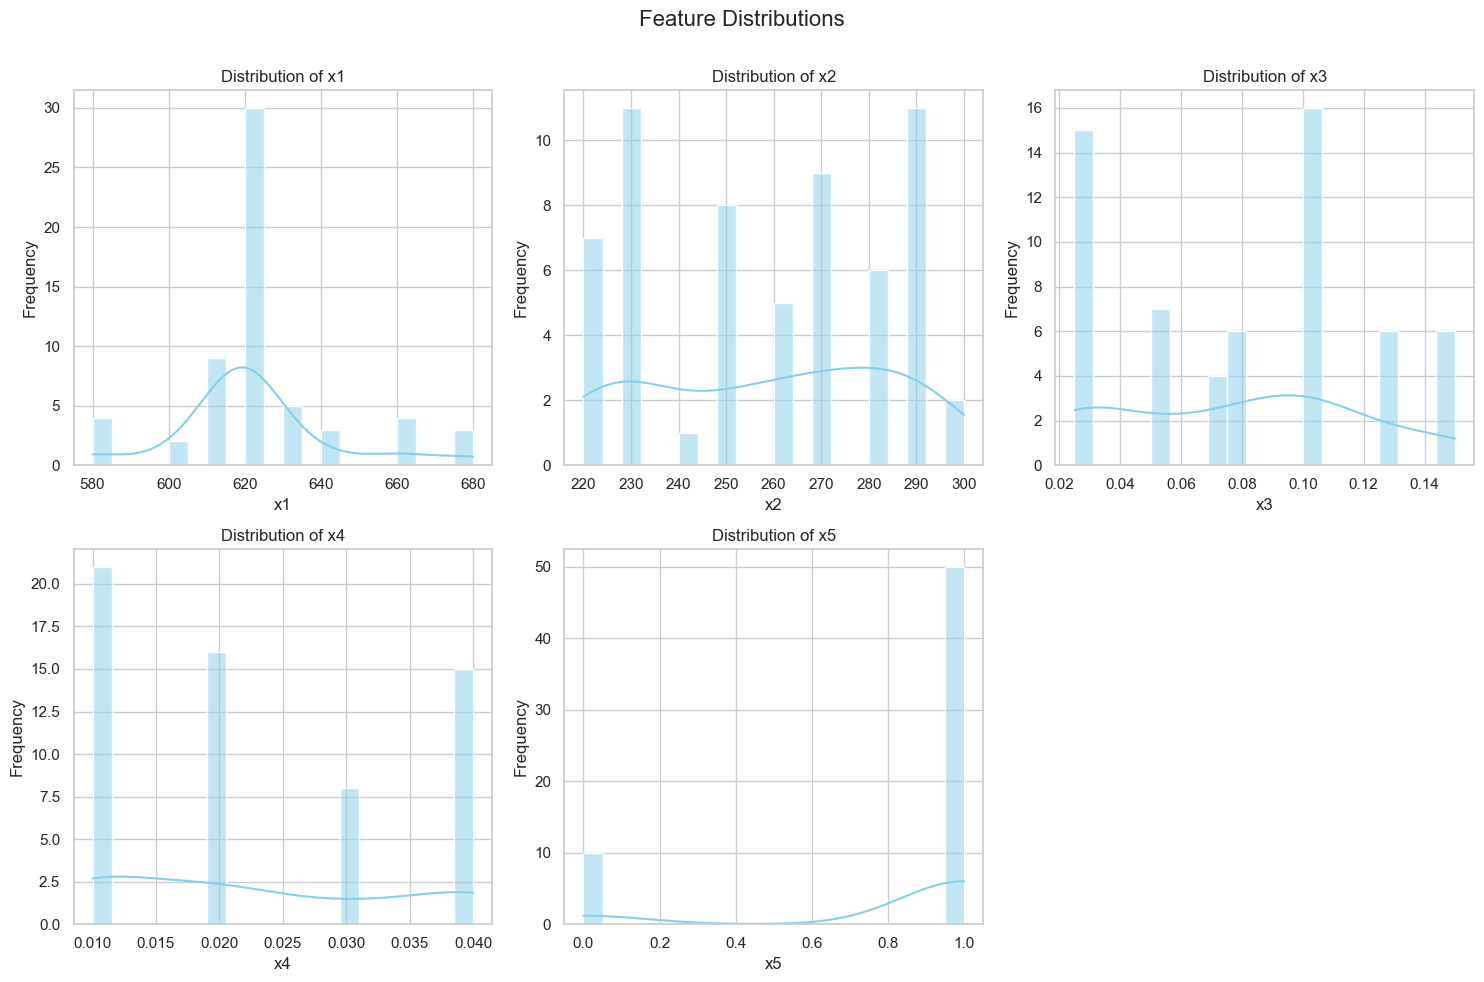

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input bayesian dataset
data = pd.read_excel('data_new.xlsx', sheet_name='bayes-01')
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
sns.set(style="whitegrid")

# Simply observe the distribution of the Bayesian data set
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  
fig.suptitle('Feature Distributions', fontsize=16)  

for i, feature in enumerate(feature_cols):
    row = i // 3  
    col = i % 3   
    ax = axes[row, col]
    
    sns.histplot(data[feature], kde=True, ax=ax, color='skyblue', bins=20)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

if len(feature_cols) < 6:
    for j in range(len(feature_cols), 6):
        row = j // 3
        col = j % 3
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

### The data point with the largest MAE was determined by k-fold k-fold cross validation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
import os

class FileManager:
    def __init__(self, base_file='Initial_data.xlsx'):
        self.base_file = base_file

    def load_data(self, sheet_name):
        """Load data"""
        try:
            data = pd.read_excel(self.base_file, sheet_name=sheet_name)
            print(f"Successfully loaded data from worksheet '{sheet_name}'")
            return data
        except Exception as e:
            print(f"Failed to load worksheet '{sheet_name}': {e}")
            return pd.DataFrame()

    @staticmethod
    def save_to_new_excel(data, file_name='Sorted_data.xlsx', sheet_name='Sorted_data', index=False):
        """Save data"""
        try:
            with pd.ExcelWriter(file_name, mode='w', engine='openpyxl') as writer:
                data.to_excel(writer, sheet_name=sheet_name, index=index)
            print(f"Successfully saved data to file '{file_name}', sheet '{sheet_name}'")
        except Exception as e:
            print(f"Failed to save data to file '{file_name}': {e}")


def load_and_preprocess_data(data):
    """Preprocess input data"""
    continuous_cols = ['x1', 'x2', 'x3', 'x4']
    categorical_cols = ['x5']
    target_col = 'y1'

    X = data.drop(target_col, axis=1)
    y = data[target_col]

    encoder = OneHotEncoder(sparse_output=False, drop=None)
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(categorical_cols, axis=1), X_encoded], axis=1)

    return X, y, data


def evaluate_model_and_store_predictions(X, y, model, num_repeats, num_folds):
    """Evaluate model performance using repeated K-Fold cross-validation"""
    all_r2_scores = []
    all_mae_scores = []
    all_rmse_scores = []
    all_predictions = []

    for j in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=j)
        fold_predictions = []

        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

            r2_fold = r2_score(y_test, y_test_pred)
            mae_fold = mean_absolute_error(y_test, y_test_pred)
            rmse_fold = np.sqrt(mean_squared_error(y_test, y_test_pred))

            all_r2_scores.append(r2_fold)
            all_mae_scores.append(mae_fold)
            all_rmse_scores.append(rmse_fold)
            fold_predictions.append(pd.Series(y_test_pred, index=test_index))

        combined_fold_predictions = pd.concat(fold_predictions).sort_index()
        all_predictions.append(combined_fold_predictions)

    all_predictions_df = pd.concat(all_predictions, axis=1)
    mean_predictions = all_predictions_df.mean(axis=1)
    std_predictions = all_predictions_df.std(axis=1)

    return mean_predictions, std_predictions, all_predictions_df, all_r2_scores, all_mae_scores, all_rmse_scores


def normalize_features(df, feature_ranges):
    """Normalize features"""
    normalized_df = df.copy()
    for col, (min_val, max_val) in feature_ranges.items():
        normalized_df[col] = (df[col] - min_val) / (max_val - min_val)
    return normalized_df


if __name__ == "__main__":

    file_manager = FileManager(base_file='Initial_data.xlsx')
    initial_data = file_manager.load_data(sheet_name='bayes-01')

    if initial_data.empty:
        print("Failed to load initial data. Please check the file content.")
        exit(1)

    X, y, data = load_and_preprocess_data(initial_data)

    xgb = XGBRegressor(max_depth=5, learning_rate=0.10, n_estimators=125,
                       reg_lambda=10, reg_alpha=0, min_child_weight=3,
                       subsample=1.0, colsample_bytree=1)

    mean_predictions, std_predictions, all_predictions_df, all_r2_scores, all_mae_scores, all_rmse_scores = \
        evaluate_model_and_store_predictions(
            X, y, xgb, num_repeats=5, num_folds=5
        )

    r2_mean = np.mean(all_r2_scores)
    r2_std = np.std(all_r2_scores)
    mae_mean = np.mean(all_mae_scores)
    mae_std = np.std(all_mae_scores)
    rmse_mean = np.mean(all_rmse_scores)
    rmse_std = np.std(all_rmse_scores)

    print("\n=== Repeated Cross-Validation Results ===")
    print(f"R² Mean: {r2_mean:.4f}, Std: {r2_std:.4f}")
    print(f"MAE Mean: {mae_mean:.4f}, Std: {mae_std:.4f}")
    print(f"RMSE Mean: {rmse_mean:.4f}, Std: {rmse_std:.4f}")

    results = pd.DataFrame({
        'Actual': y,
        'Mean_Prediction': mean_predictions,
        'Std_Prediction': std_predictions
    })
    results = pd.concat([X, results], axis=1)
    results['Absolute_Error'] = np.abs(results['Actual'] - results['Mean_Prediction'])
    results_sorted = results.sort_values(by='Absolute_Error', ascending=False)

    FileManager.save_to_new_excel(results_sorted, file_name='Sorted_data.xlsx', sheet_name='Sorted_data', index=True)

    # Option to normalize features
    need_normalize = False  # Set to True if normalization is needed
    if need_normalize:
        feature_ranges = {
            'x1': (580, 680),
            'x2': (220, 300),
            'x3': (0.025, 0.15),
            'x4': (0.01, 0.04)
        }
        X_normalized = normalize_features(X, feature_ranges)

Successfully loaded data from worksheet 'bayes-01'

=== Repeated Cross-Validation Results ===
R² Mean: 0.7122, Std: 0.2139
MAE Mean: 0.0455, Std: 0.0156
RMSE Mean: 0.0595, Std: 0.0230
Successfully saved data to file 'Sorted_data.xlsx', sheet 'Sorted_data'
